In [9]:
# from IPython.core.display import display, HTML 
# display(HTML('<style>.container {​​​​​​​ width:90% !important; }​​​​​​​</style>'))

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import re

# import xlrd
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('seaborn') #그래프 스타일

# plt.rc('font', family='AppleGothic') #그래프 한글
# matplotlib.rcParams['axes.unicode_minus'] = False #마이너스값
# matplotlib의 기본 폰트를 변경
plt.rcParams['font.family'] = 'DejaVu Sans'  # 예: 'DejaVu Sans' 폰트로 변경


#화면에 출력되는 데이터 갯수
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 200)

%config InlineBackend.figure_format='retina'
%matplotlib inline


from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.all import *
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
data = [] #
labels = [] # label

for root, dirs, files  in os.walk('/Users/kimsy/DataScience/dataset/fm_img/horizontal/train'):
    if 'good' in root or 'ng' in root:
        for file in files:
            if file.endswith('.jpg')or file.endswith('.png'):
                data.append(os.path.join(root, file))
                labels.append('good' if 'good' in root else 'ng')


df = pd.DataFrame({'path':data, 'label':labels})
df

,path,label
0,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/ng/2022-12-27-152122551.jpg,ng
1,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/ng/2022-12-27-162306690.jpg,ng
2,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/ng/2022-12-27-163254599.jpg,ng
3,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/ng/2022-12-27-163932958.jpg,ng
4,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/ng/2022-12-27-162748046.jpg,ng
...,...,...
915,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/good/2022-12-27-150455831.jpg,good
916,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/good/2022-12-27-150056856.jpg,good
917,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/good/2022-12-27-150223726.jpg,good
918,/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/good/2022-12-27-150524574.jpg,good


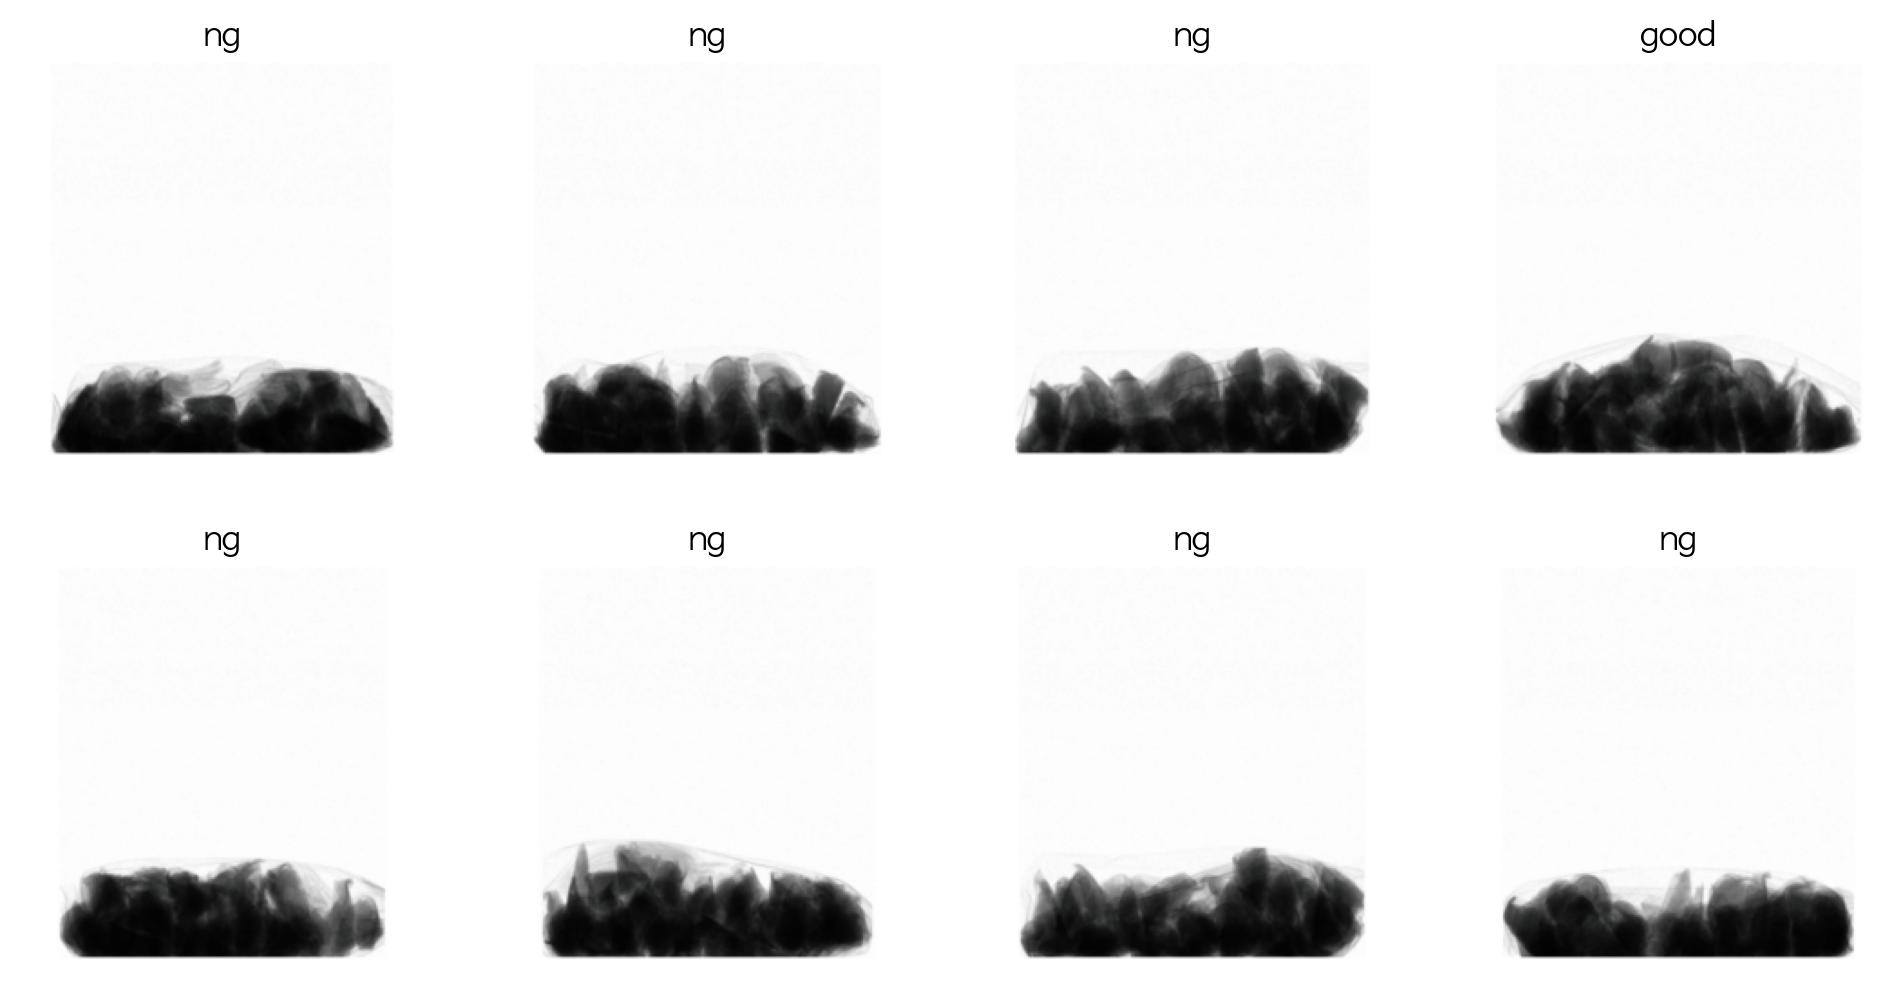

In [4]:
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from vit_pytorch import ViT


# ResNet50과 ViT 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        self.resnet50 = create_cnn_model(resnet50, n_out=dls.c)
        self.vit = ViT(
            image_size=224,
            patch_size=32,
            num_classes=dls.c,
            dim=1024,
            depth=6,
            heads=8,
            mlp_dim=2048,
            dropout=0.1,
            emb_dropout=0.1
        )
    
    def forward(self, x):
        resnet_out = self.resnet50(x)
        vit_out = self.vit(x)
        return (resnet_out + vit_out) / 2



# 데이터 로드 및 전처리
# path = Path('datasets/train')
# dls = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.2, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))




dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_x = ColReader('path', pref = ''), # 이미 경로가 path 열에 정보가 있기 때문에 pref는 '' 빈 정보로
                get_y = ColReader('label'),
                batch_tfms=Normalize.from_stats(*imagenet_stats),
                # batch_tfms = aug_transforms(size = 224),
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                item_tfms = [Resize(224)])

dls = dls.dataloaders(df, bs=16)

dls.show_batch(max_n=8)


SuggestedLRs(valley=0.00010964782268274575)

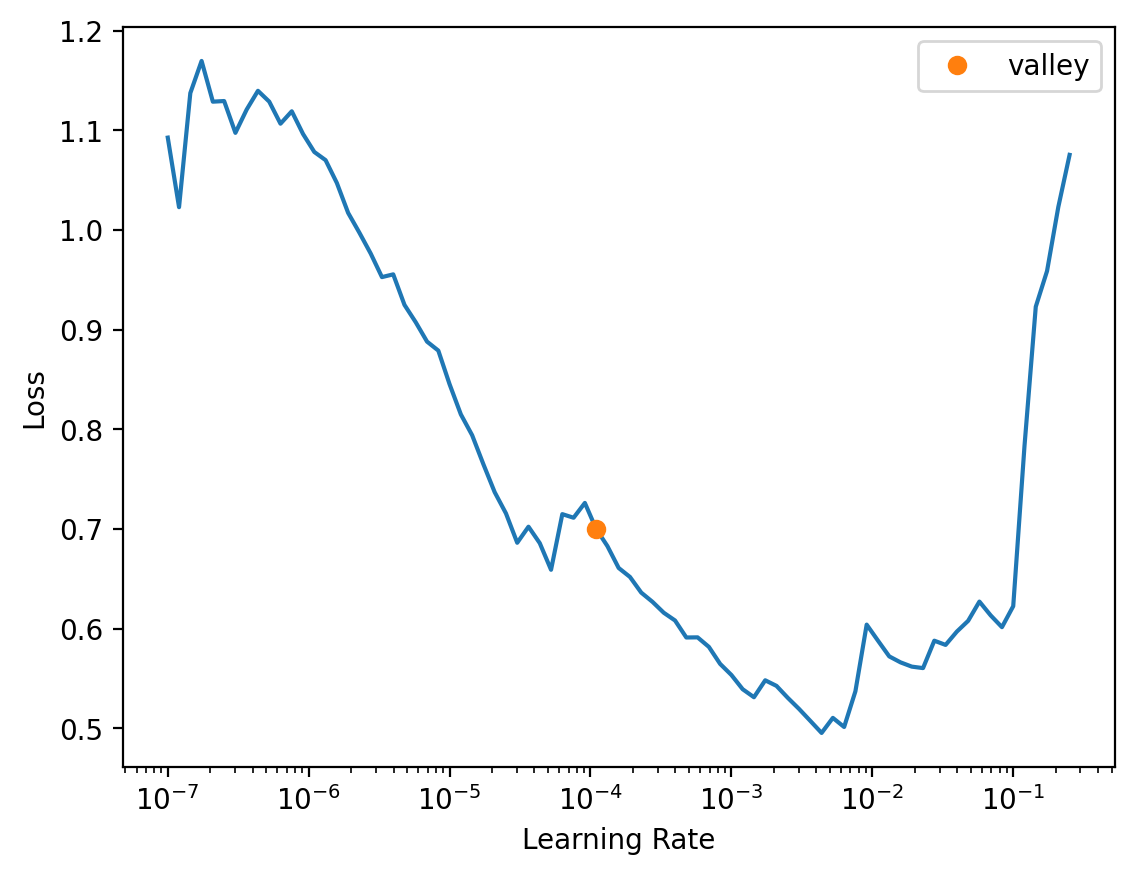

In [10]:

model = EnsembleModel()

# Good confidence 60% 이하 판정 수정
def modified_accuracy(inp, targ, axis=-1):
    pred = inp.argmax(dim=axis)
    good_confidence = F.softmax(inp, dim=axis)[:, 1]
    pred[good_confidence <= 0.6] = 0
    return (pred == targ).float().mean()

# Learner 정의
learn = Learner(dls, model, metrics=modified_accuracy, cbs=EarlyStoppingCallback(patience=3))

# 학습률 찾기
learn.lr_find()


In [11]:

# 그래프에서 추천되는 학습률을 확인하고, 해당 학습률을 사용하여 학습
lr = 1e-3  # lr_find 그래프에서 추천되는 학습률로 수정
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,modified_accuracy,time
0,0.282969,0.218601,0.918478,00:24
1,0.271746,9.492616,0.119565,00:23
2,0.182262,0.110500,0.961957,00:23
3,0.189419,0.761419,0.880435,00:23
4,0.153937,0.201250,0.885870,00:23
5,0.110753,0.992273,0.451087,00:23


No improvement since epoch 2: early stopping


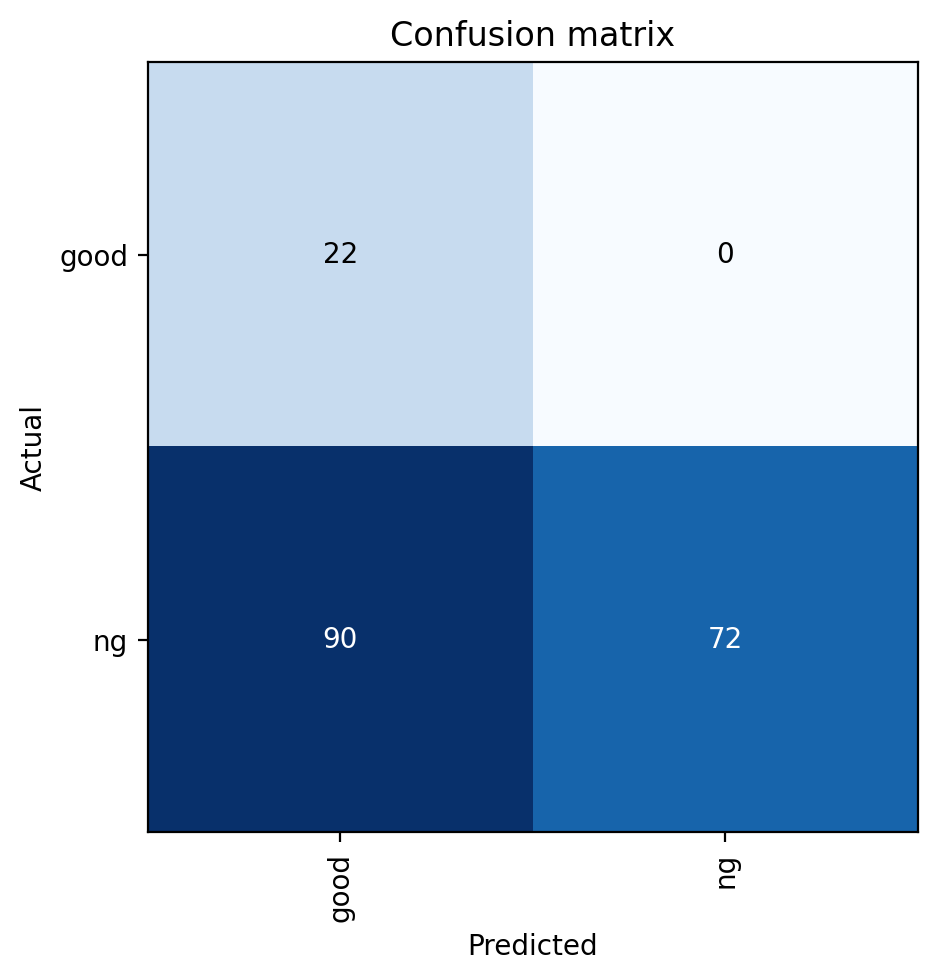

In [12]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

interp.plot_confusion_matrix()